# Graphs networks on molecules

## Setup custom stuff for the colab (packages, data)

In [1]:
# Modern setup for PyTorch, PyG, RDKit, and W&B
# No miniconda installation needed - using native Colab Python

# Install uv first
!pip install uv

# Install modern packages using uv
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !uv pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!uv pip install torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!uv pip install pytorch-lightning==2.1.0
!uv pip install rdkit==2024.3.6
!uv pip install wandb
!uv pip install bayesian-optimization
!uv pip install torch-uncertainty
!uv pip install scikit-learn pandas matplotlib seaborn tqdm

print('=' * 80)
print('Installation complete!')
print('=' * 80)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 20.8 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Audited 3 packages in 244ms
Using Python 3.12.12 environment at: /usr
Resolved 23 packages in 1.09s
Prepared 1 package in 157ms
Installed 1 package in 34ms
 + torch-geometric==2.7.0
Using Python 3.12.12 environment at: /usr
Resolved 42 packages in 257ms
Prepared 3 packages in 215ms
Installed 3 packages in 35ms
 + lightning-utilities==0.15.2
 + pytorch-lightning==2.1.0
 + torchmetrics==1.8.2
Using Python 3.12.12 environment at: /usr
Resolved 3 packages in 338ms
Prepared 1 package in 9.64s
Installed 1 package in 18ms
 + rdkit==2024.3.6
Using Python 3.12.12 environment at: /usr
Audited 1 package in 134ms
Using Python 3.12.12 environment at: /usr
Resolved 7 packages in 308ms
Prepared 2 packages in 7ms
Installed 2 packages in 2ms
 + bayesian-optimization==3.1.0
 + colorama==0.4.6
Using Python 3.12.12 environment at: /usr
Resolved 82 packages in 1.00s
Prepared 8 packages i

## Import libraries


In [2]:
# Import libraries
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Progress bar
from tqdm import tqdm

# Scientific Python stack
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cheminformatics
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

# Machine Learning / Deep Learning
import sklearn
from sklearn import model_selection, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PyTorch ecosystem
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.utils import add_self_loops

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

# Bayesian optimization - handle both v1.x and v2.0+ APIs
from bayes_opt import BayesianOptimization
try:
    # Try v1.x API first
    from bayes_opt import UtilityFunction
    BAYESOPT_VERSION = 'v1.x'
    print('Using bayesian-optimization v1.x API (UtilityFunction)')
except ImportError:
    # Fall back to v2.0+ API
    try:
        from bayes_opt.acquisition import UpperConfidenceBound
        BAYESOPT_VERSION = 'v2.0+'
        print('Using bayesian-optimization v2.0+ API (AcquisitionFunction)')
    except ImportError:
        print('Warning: Could not import bayesian-optimization utilities')
        BAYESOPT_VERSION = None

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed, workers=True)

set_seed(42)

# Gomes Group color palette
GOMES_COLORS = {
    'teal': '#00D9FF',
    'coral': '#FF6B6B',
    'navy': '#0A1628',
    'light_teal': '#7FECFF',
    'light_coral': '#FF9999'
}

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette([GOMES_COLORS['teal'], GOMES_COLORS['coral'], GOMES_COLORS['navy']])

# Print versions
print('RDKit: {}'.format(rdkit.__version__))
print('PyTorch: {}'.format(torch.__version__))
print('PyTorch Geometric: {}'.format(torch_geometric.__version__))
print('PyTorch Lightning: {}'.format(pl.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using bayesian-optimization v2.0+ API (AcquisitionFunction)
RDKit: 2024.03.6
PyTorch: 2.9.0+cu126
PyTorch Geometric: 2.7.0
PyTorch Lightning: 2.1.0
CUDA available: True


# Task and data: predict solubility (logP) 💧

Datatset source: Delaney's solubility dataset from ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure
(https://pubs.acs.org/doi/10.1021/ci034243x)


#### Machine learning and deep learning in a nutshell

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/ml_dl.png?raw=true)


## Let's load some molecular data with 🐼s

In [3]:
# Load ESOL solubility dataset
# Check if data directory exists, if not download from repo
import os
if not os.path.exists('data/solubility.csv'):
    !mkdir -p data
    !wget -q https://raw.githubusercontent.com/beangoben/chemistry_ml_colab/master/data/solubility.csv -O data/solubility.csv

df = pd.read_csv('data/solubility.csv')
print('Dataset shape:', df.shape)
print('\nColumns:', list(df.columns))

# Define column names
smiles_column = 'smiles'
target = 'measured log solubility in mols per litre'

# Display first few rows
df.head()

Dataset shape: (1128, 10)

Columns: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   
1                          2               42.24   
2                          4               17.07   
3                          0                0.00   
4                          0                0.00   

   measured log solubility in mols per litre  \
0                                      -0.77   
1                                      -3.30   
2                                      -2.06   
3                                      -7.87   
4                                      -1.33   

                                              smiles  
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...  
1                             Cc1occc1C(=O)Nc2ccccc2  
2                               CC(C)=CCCC(C)=CC(=O)  
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43  
4                                            c1ccsc1

## Let's prepare our y data and our splits

Target shape: (1128, 1)
Train samples: 902, Test samples: 226


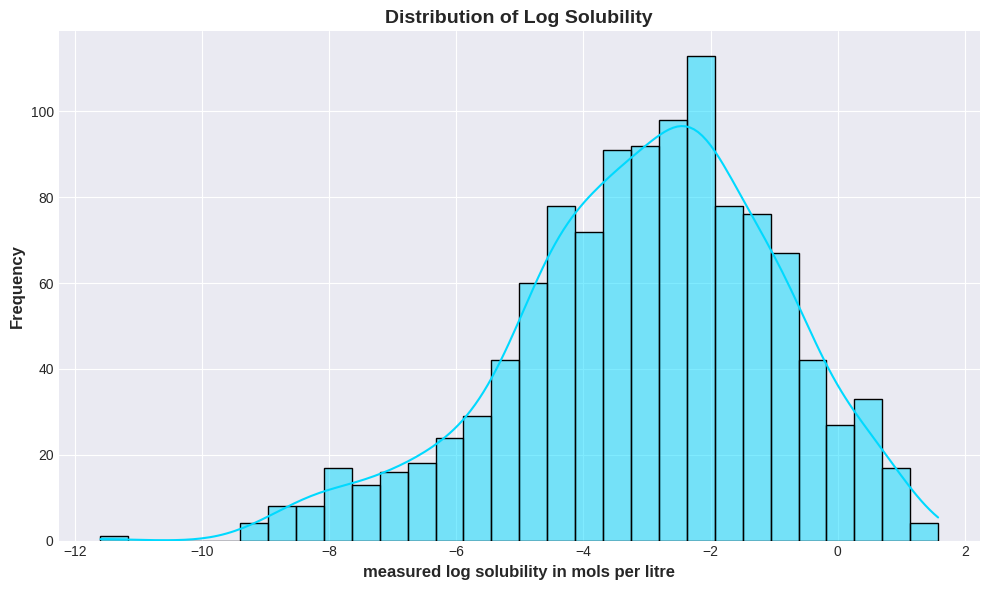


Target statistics:
  Mean: -3.050
  Std: 2.096
  Min: -11.600
  Max: 1.580


In [4]:
# Prepare target values and train/test splits
y = df[target].values.reshape(-1, 1)
print('Target shape:', y.shape)

# Create train/test split with fixed random state for reproducibility
indices = df.index.tolist()
train_index, test_index = model_selection.train_test_split(
    indices,
    test_size=0.2,
    random_state=42
)
print(f'Train samples: {len(train_index)}, Test samples: {len(test_index)}')

# Visualize target distribution with Gomes Group colors
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(y.ravel(), bins=30, kde=True, color=GOMES_COLORS['teal'], ax=ax)
ax.set_xlabel(target, fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Log Solubility', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Basic statistics
print(f'\nTarget statistics:')
print(f'  Mean: {y.mean():.3f}')
print(f'  Std: {y.std():.3f}')
print(f'  Min: {y.min():.3f}')
print(f'  Max: {y.max():.3f}')

## Let's prepare out molecular graphs (x)

There are two steps to understand:

1) Generate atomic and bond features

2) For each molecule, compute features and store this information as tensors

### Molecular features


![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/mol_tensors.png?raw=true)

In [5]:
# Modern molecular featurization using OGB-style approach
# Based on: https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py

# Allowable atom features
allowable_features = {
    'possible_atomic_num_list': list(range(1, 119)) + ['misc'],
    'possible_chirality_list': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER'
    ],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list': [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
    ],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring_list': [False, True]
}

# Allowable bond features
allowable_bond_features = {
    'possible_bond_type_list': [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'possible_bond_stereo_list': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'possible_is_conjugated_list': [False, True],
}


def safe_index(l, e):
    """
    Return index of element e in list l. If e is not present, return the last index
    """
    try:
        return l.index(e)
    except:
        return len(l) - 1


def atom_to_feature_vector(atom):
    """
    Converts RDKit atom object to feature list of indices
    """
    atom_feature = [
        safe_index(allowable_features['possible_atomic_num_list'], atom.GetAtomicNum()),
        allowable_features['possible_chirality_list'].index(str(atom.GetChiralTag())),
        safe_index(allowable_features['possible_degree_list'], atom.GetTotalDegree()),
        safe_index(allowable_features['possible_formal_charge_list'], atom.GetFormalCharge()),
        safe_index(allowable_features['possible_numH_list'], atom.GetTotalNumHs()),
        safe_index(allowable_features['possible_number_radical_e_list'], atom.GetNumRadicalElectrons()),
        safe_index(allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
        allowable_features['possible_is_aromatic_list'].index(atom.GetIsAromatic()),
        allowable_features['possible_is_in_ring_list'].index(atom.IsInRing()),
    ]
    return atom_feature


def bond_to_feature_vector(bond):
    """
    Converts RDKit bond object to feature list of indices
    """
    bond_feature = [
        safe_index(allowable_bond_features['possible_bond_type_list'], str(bond.GetBondType())),
        allowable_bond_features['possible_bond_stereo_list'].index(str(bond.GetStereo())),
        allowable_bond_features['possible_is_conjugated_list'].index(bond.GetIsConjugated()),
    ]
    return bond_feature


def atom_feature_vector_to_dict(atom_feature):
    """Helper function to convert atom feature vector to dictionary"""
    feature_names = ['atomic_num', 'chirality', 'degree', 'formal_charge',
                     'num_h', 'num_rad_e', 'hybridization', 'is_aromatic', 'is_in_ring']
    return {k: v for k, v in zip(feature_names, atom_feature)}


def bond_feature_vector_to_dict(bond_feature):
    """Helper function to convert bond feature vector to dictionary"""
    feature_names = ['bond_type', 'bond_stereo', 'is_conjugated']
    return {k: v for k, v in zip(feature_names, bond_feature)}


# Print feature dimensions
print(f'Atom feature dimension: {len(atom_to_feature_vector(Chem.MolFromSmiles("C").GetAtomWithIdx(0)))}')
print(f'Bond feature dimension: {len(bond_to_feature_vector(Chem.MolFromSmiles("CC").GetBondWithIdx(0)))}')

# Example: Extract features for a simple molecule
mol = Chem.MolFromSmiles('CCO')
atom_features = [atom_to_feature_vector(atom) for atom in mol.GetAtoms()]
print(f'\nExample molecule: CCO (ethanol)')
print(f'Number of atoms: {len(atom_features)}')
print(f'First atom features: {atom_features[0]}')

Atom feature dimension: 9
Bond feature dimension: 3

Example molecule: CCO (ethanol)
Number of atoms: 3
First atom features: [5, 0, 4, 5, 3, 0, 2, 0, 0]


### Mol Tensorizer

In [6]:
def smiles_to_pyg_graph(smiles_string):
    """
    Convert SMILES string to PyTorch Geometric Data object
    Returns a graph with node features, edge indices, and edge features
    """
    mol = Chem.MolFromSmiles(smiles_string)

    if mol is None:
        return None

    # Get atom features
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = torch.tensor(atom_features_list, dtype=torch.long)

    # Get bond features and edge indices
    num_bond_features = 3  # bond type, bond stereo, is_conjugated

    if len(mol.GetBonds()) > 0:  # molecule has bonds
        edges_list = []
        edge_features_list = []

        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # Add both directions since molecular graphs are undirected
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # Convert to tensor format: shape [2, num_edges]
        edge_index = torch.tensor(edges_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features_list, dtype=torch.long)
    else:  # molecule has no bonds (single atom)
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, num_bond_features), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data


# Example: Convert a few molecules to graph format
print('Converting SMILES to PyTorch Geometric graphs...\n')

example_smiles = ['C', 'CCO', 'c1ccccc1']  # methane, ethanol, benzene
example_names = ['Methane', 'Ethanol', 'Benzene']

for name, smi in zip(example_names, example_smiles):
    graph = smiles_to_pyg_graph(smi)
    print(f'{name} ({smi}):')
    print(f'  Nodes: {graph.num_nodes}')
    print(f'  Edges: {graph.num_edges}')
    print(f'  Node feature shape: {graph.x.shape}')
    print(f'  Edge feature shape: {graph.edge_attr.shape}')
    print(f'  Edge index shape: {graph.edge_index.shape}\n')

Converting SMILES to PyTorch Geometric graphs...

Methane (C):
  Nodes: 1
  Edges: 0
  Node feature shape: torch.Size([1, 9])
  Edge feature shape: torch.Size([0, 3])
  Edge index shape: torch.Size([2, 0])

Ethanol (CCO):
  Nodes: 3
  Edges: 4
  Node feature shape: torch.Size([3, 9])
  Edge feature shape: torch.Size([4, 3])
  Edge index shape: torch.Size([2, 4])

Benzene (c1ccccc1):
  Nodes: 6
  Edges: 12
  Node feature shape: torch.Size([6, 9])
  Edge feature shape: torch.Size([12, 3])
  Edge index shape: torch.Size([2, 12])



### Ready to tensorize!

In [7]:
# Convert all molecules to PyG graphs
print('Converting ESOL dataset to PyG graphs...')

smiles_list = df[smiles_column].tolist()
graph_list = []

for i, smi in enumerate(tqdm(smiles_list)):
    graph = smiles_to_pyg_graph(smi)
    if graph is not None:
        # Add target value to graph
        graph.y = torch.tensor([y[i, 0]], dtype=torch.float)
        graph_list.append(graph)
    else:
        print(f'Warning: Could not parse SMILES at index {i}: {smi}')

print(f'\nSuccessfully converted {len(graph_list)} molecules to graphs')
print(f'Example graph:')
print(graph_list[0])

# Create train and test graph lists
train_graphs = [graph_list[i] for i in train_index if i < len(graph_list)]
test_graphs = [graph_list[i] for i in test_index if i < len(graph_list)]

print(f'\nTrain graphs: {len(train_graphs)}')
print(f'Test graphs: {len(test_graphs)}')

Converting ESOL dataset to PyG graphs...


100%|██████████| 1128/1128 [00:00<00:00, 2014.61it/s]


Successfully converted 1128 molecules to graphs
Example graph:
Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1])

Train graphs: 902
Test graphs: 226


# Graph Convolution Networks

We need to define:

* Input layer, what data are we feeding to the network? (how do we represent a molecular graph)
* GraphConvolution Layer , how do we learn a new node-level representation?
* GraphEmbedding Layer, how do we project our graph to a vector?
* (optionally) FC layers (Neural network), to increase prediction performance.
* Prediction layer , aka a Generalized Linear Model

## Input layer:

In [8]:
# Create PyTorch Dataset for molecular graphs
from torch.utils.data import Dataset as TorchDataset

class MoleculeDataset(TorchDataset):
    """
    PyTorch Dataset for molecular graphs
    """
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


# Create datasets
train_dataset = MoleculeDataset(train_graphs)
test_dataset = MoleculeDataset(test_graphs)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'\nExample data point:')
print(train_dataset[0])

Train dataset size: 902
Test dataset size: 226

Example data point:
Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], y=[1])


## Graph convolution layer


![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_one.png?raw=true)
![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_two.png?raw=true)
![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_layers.png?raw=true)
![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_connected.png?raw=true)

In [9]:
# Graph Convolution Layer using PyTorch Geometric MessagePassing
# This replaces the custom TensorFlow GraphConvolution layer

class GCNConv(MessagePassing):
    """
    Graph Convolutional Network layer that aggregates neighbor information
    Similar to the original TensorFlow implementation but using PyG's MessagePassing
    """
    def __init__(self, in_channels, out_channels, edge_dim, activation='relu'):
        super(GCNConv, self).__init__(aggr='add')  # Use sum aggregation

        # Combine atom and bond features
        self.lin = nn.Linear(in_channels + edge_dim, out_channels)

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'softplus':
            self.activation = nn.Softplus()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Identity()

    def forward(self, x, edge_index, edge_attr):
        """
        x: Node feature matrix [num_nodes, in_channels]
        edge_index: Graph connectivity [2, num_edges]
        edge_attr: Edge feature matrix [num_edges, edge_dim]
        """
        # Add self-loops to edge_index
        edge_index, edge_attr = add_self_loops(
            edge_index, edge_attr,
            fill_value=0.0,
            num_nodes=x.size(0)
        )

        # Start propagating messages
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        return self.activation(out)

    def message(self, x_j, edge_attr):
        """
        x_j: Features of source nodes [num_edges, in_channels]
        edge_attr: Edge features [num_edges, edge_dim]
        """
        # Concatenate node and edge features
        combined = torch.cat([x_j, edge_attr], dim=-1)
        return self.lin(combined)


# Example usage
print('GCN Convolution Layer Example:')
print('Input: atom features + edge features')
print('Output: updated atom features after message passing')
print('\nThe layer performs:')
print('1. Gather features from neighboring atoms')
print('2. Concatenate with bond (edge) features')
print('3. Transform through linear layer')
print('4. Apply activation function')

GCN Convolution Layer Example:
Input: atom features + edge features
Output: updated atom features after message passing

The layer performs:
1. Gather features from neighboring atoms
2. Concatenate with bond (edge) features
3. Transform through linear layer
4. Apply activation function


## GraphEmbedding layer

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/GCN_emb.png?raw=true)

In [10]:
# Graph Embedding Layer for global pooling
# This replaces the custom TensorFlow GraphEmbedding layer

class GraphPooling(nn.Module):
    """
    Pools node-level features to graph-level representation
    Uses global sum pooling (can also use mean, max, or attention-based pooling)
    """
    def __init__(self, in_channels, embedding_dim, activation='softmax'):
        super(GraphPooling, self).__init__()

        self.transform = nn.Linear(in_channels, embedding_dim)

        # Activation function
        if activation == 'softmax':
            self.activation = nn.Softmax(dim=-1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'softplus':
            self.activation = nn.Softplus()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Identity()

    def forward(self, x, batch):
        """
        x: Node features [num_nodes_in_batch, in_channels]
        batch: Batch vector [num_nodes_in_batch] indicating which graph each node belongs to
        """
        # Transform node features
        x = self.activation(self.transform(x))

        # Global pooling: sum node features for each graph
        out = global_add_pool(x, batch)

        return out


# Example usage
print('Graph Pooling Layer Example:')
print('Input: node-level features from all atoms')
print('Output: single fixed-size vector per molecule')
print('\nThe layer performs:')
print('1. Transform each atom feature through linear layer')
print('2. Apply activation function')
print('3. Sum (pool) all atom features to get molecule representation')

Graph Pooling Layer Example:
Input: node-level features from all atoms
Output: single fixed-size vector per molecule

The layer performs:
1. Transform each atom feature through linear layer
2. Apply activation function
3. Sum (pool) all atom features to get molecule representation


## Layers.... assemble!

In [11]:
# Complete GNN Model using PyTorch Lightning
# This combines GCN layers, graph pooling, and prediction in one model

class MoleculeGNN(pl.LightningModule):
    """
    Graph Neural Network for molecular property prediction
    Architecture: Atom Embedding -> GCN Layers -> Graph Pooling -> MLP -> Prediction
    """
    def __init__(
        self,
        num_atom_features=9,
        num_bond_features=3,
        hidden_channels=64,
        num_conv_layers=4,
        embedding_dim=128,
        dropout=0.0,
        conv_activation='relu',
        pool_activation='softmax',
        learning_rate=0.001
    ):
        super(MoleculeGNN, self).__init__()
        self.save_hyperparameters()

        # Atom feature embedding (convert categorical features to continuous)
        self.atom_embedding = nn.Embedding(
            num_embeddings=119,  # Max atomic number
            embedding_dim=hidden_channels
        )

        # GCN layers
        self.convs = nn.ModuleList()
        in_channels = hidden_channels

        for i in range(num_conv_layers):
            out_channels = hidden_channels * (i + 1)
            self.convs.append(
                GCNConv(in_channels, out_channels, num_bond_features, conv_activation)
            )
            in_channels = out_channels

        # Graph pooling layer
        self.pool = GraphPooling(in_channels, embedding_dim, pool_activation)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Prediction head
        self.predictor = nn.Linear(embedding_dim, 1)

        # Normalization (will be set during training)
        self.register_buffer('y_mean', torch.tensor([0.0]))
        self.register_buffer('y_std', torch.tensor([1.0]))

    def forward(self, batch):
        """
        Forward pass through the network
        """
        x, edge_index, edge_attr, batch_idx = batch.x, batch.edge_index, batch.edge_attr, batch.batch

        # Embed atom features (only use atomic number for embedding)
        x = self.atom_embedding(x[:, 0])  # Use first feature (atomic number)

        # Convert edge attributes to float
        edge_attr = edge_attr.float()

        # Apply GCN layers
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = self.dropout(x)

        # Pool to graph-level representation
        x = self.pool(x, batch_idx)

        # Predict
        out = self.predictor(x)

        return out

    def training_step(self, batch, batch_idx):
        y_pred = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('train_loss', loss, batch_size=len(batch.y))
        self.log('train_mae', mae, batch_size=len(batch.y))

        return loss

    def validation_step(self, batch, batch_idx):
        y_pred = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('val_loss', loss, batch_size=len(batch.y), prog_bar=True)
        self.log('val_mae', mae, batch_size=len(batch.y), prog_bar=True)

        return {'val_loss': loss, 'val_mae': mae, 'y_pred': y_pred, 'y_true': y_true}

    def test_step(self, batch, batch_idx):
        y_pred = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('test_loss', loss, batch_size=len(batch.y))
        self.log('test_mae', mae, batch_size=len(batch.y))

        return {'test_loss': loss, 'test_mae': mae, 'y_pred': y_pred, 'y_true': y_true}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }


# Create a simple model
model = MoleculeGNN(
    num_atom_features=9,
    num_bond_features=3,
    hidden_channels=32,
    num_conv_layers=3,
    embedding_dim=128,
    dropout=0.1,
    learning_rate=0.001
)

print('Model architecture:')
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

Model architecture:
MoleculeGNN(
  (atom_embedding): Embedding(119, 32)
  (convs): ModuleList(
    (0-2): 3 x GCNConv()
  )
  (pool): GraphPooling(
    (transform): Linear(in_features=96, out_features=128, bias=True)
    (activation): Softmax(dim=-1)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 26,337


In [12]:
# Create DataLoaders
from torch_geometric.loader import DataLoader as PyGDataLoader

# DataLoader for PyG graphs
train_loader = PyGDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = PyGDataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')

# Check a batch
example_batch = next(iter(train_loader))
print(f'\nExample batch:')
print(f'  Batch size: {example_batch.num_graphs}')
print(f'  Total nodes in batch: {example_batch.num_nodes}')
print(f'  Total edges in batch: {example_batch.num_edges}')
print(f'  Node features shape: {example_batch.x.shape}')
print(f'  Edge features shape: {example_batch.edge_attr.shape}')
print(f'  Target shape: {example_batch.y.shape}')

Number of training batches: 15
Number of test batches: 4

Example batch:
  Batch size: 64
  Total nodes in batch: 885
  Total edges in batch: 1814
  Node features shape: torch.Size([885, 9])
  Edge features shape: torch.Size([1814, 3])
  Target shape: torch.Size([64])


In [13]:
# Training setup with PyTorch Lightning

# Create model
model = MoleculeGNN(
    num_atom_features=9,
    num_bond_features=3,
    hidden_channels=32,
    num_conv_layers=4,
    embedding_dim=128,
    dropout=0.05,
    conv_activation='relu',
    pool_activation='softmax',
    learning_rate=0.001
)

# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='gnn-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Create trainer (without W&B for simplicity)
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    accelerator='auto',
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
    deterministic=True
)

# Train model
print('Starting training...\n')
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting training...



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type         | Params
------------------------------------------------
0 | atom_embedding | Embedding    | 3.8 K 
1 | convs          | ModuleList   | 22.8 K
2 | pool           | GraphPooling | 16.5 K
3 | dropout        | Dropout      | 0     
4 | predictor      | Linear       | 129   
------------------------------------------------
43.2 K    Trainable params
0         Non-trainable params
43.2 K    Total params
0.173     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 6.231


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.806 >= min_delta = 0.0. New best score: 5.425


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.658 >= min_delta = 0.0. New best score: 4.767


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.512 >= min_delta = 0.0. New best score: 4.255


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.390 >= min_delta = 0.0. New best score: 3.865


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 3.605


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 3.443


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 3.322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 3.232


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 3.166


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 3.134


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 3.116


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 3.104


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 3.099


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 3.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 3.086


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.085


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.085


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 3.083


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.083


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.080


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 3.075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.074


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.073


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.467 >= min_delta = 0.0. New best score: 2.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 2.594


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.195 >= min_delta = 0.0. New best score: 2.400


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 2.203


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 2.079


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 2.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 1.917


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 1.756


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 1.630


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.584


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.559


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.495


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 1.388


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.342


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.261


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.223


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.178


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.141


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.134


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.115


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.103


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.072


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.052


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### Some training stats

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/gnn-epoch=87-val_loss=1.0524.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/gnn-epoch=87-val_loss=1.0524.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.0523649454116821     │
│         test_mae          │    0.7648767232894897     │
└───────────────────────────┴───────────────────────────┘

Test Set Performance:
  R2 Score: 0.7774
  RMSE: 1.0258
  MAE: 0.7649


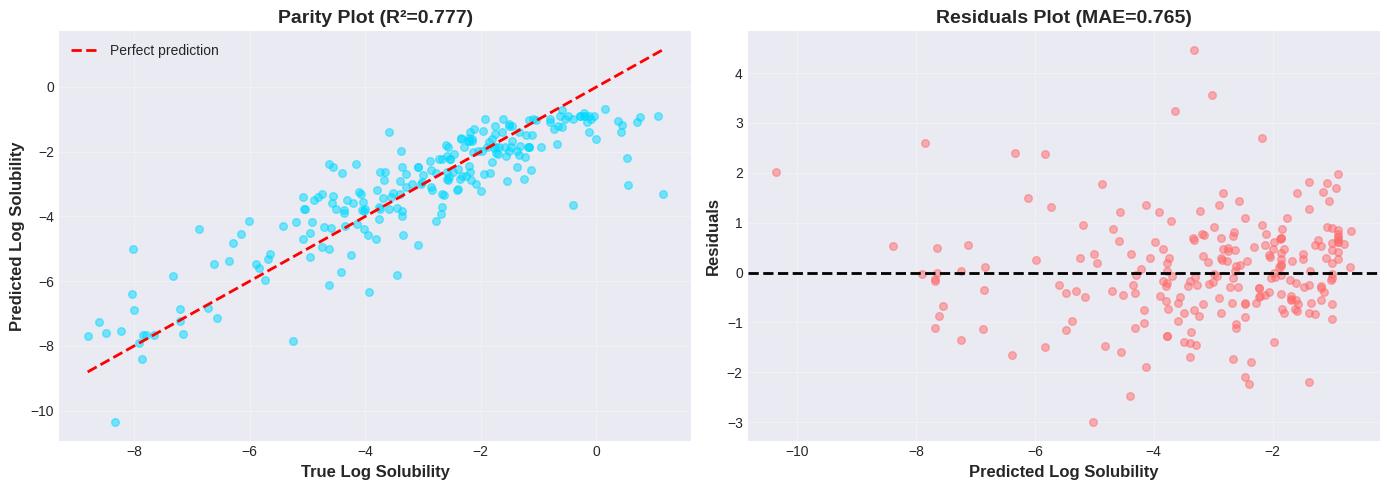

In [14]:
# Evaluate model and visualize results
# Test the best model
test_results = trainer.test(model, test_loader, ckpt_path='best')

# Get predictions
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        preds = model(batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())

y_pred = np.concatenate(all_preds, axis=0).ravel()
y_test = np.concatenate(all_targets, axis=0).ravel()

# Calculate metrics
r2 = metrics.r2_score(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

print(f'Test Set Performance:')
print(f'  R2 Score: {r2:.4f}')
print(f'  RMSE: {rmse:.4f}')
print(f'  MAE: {mae:.4f}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parity plot
axes[0].scatter(y_test, y_pred, alpha=0.5, c=GOMES_COLORS['teal'], s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Log Solubility', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Log Solubility', fontsize=12, fontweight='bold')
axes[0].set_title(f'Parity Plot (R²={r2:.3f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, c=GOMES_COLORS['coral'], s=30)
axes[1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Log Solubility', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_title(f'Residuals Plot (MAE={mae:.3f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## A good template for a GCN

In [16]:
hparams = {
    "fp_depth": 5,
    "fp_layer_size": 270,
    "fp_activation": "softmax",
    #"fp_l1": 1.9624592815875186e-05,
    #"fp_l2": 0.00021787629651043338,
    "fp_dropout": 0.0,
    "fp_batchnorm": False,
    "fp_merge_mode": "residual",
    "conv_base_layer_size": 28,
    "conv_layer_size_ratio": 1.51,
    "conv_activation": "relu",

    #"conv_l1": 8.217857229994724e-06,
    #"conv_l2": 0.014418374965506497,
    "conv_dropout": 0.05227018814431583,
    "conv_batchnorm": True,
    #"conv_graphpool": "none",
    #"conv_n_layers": 1,

    "net_depth": 0,
    "net_base_layer_size": 128,
    "net_layer_size_ratio": 1.1,
    "net_activation": "relu",
    "net_use_bias": False,
    "net_l1": 0.0,
    "net_l2": 0.0,
    "net_dropout": 0.25,
    "net_batchnorm": False,
    "epochs": 50,
    "batch_size": 64,
    "n_folds": 1,
    "learning_rate": 0.00016344199030918218,
    "lr_scheduler": "decay_restart"
}

In [17]:
# Advanced GNN with residual connections and deeper architecture
# This implements a more sophisticated model similar to the original cells 31-34

class AdvancedMoleculeGNN(pl.LightningModule):
    """
    Advanced GNN with:
    - Multiple GCN layers with increasing hidden dimensions
    - Residual/skip connections between layers
    - Graph-level embeddings from multiple layers
    - Batch normalization and dropout
    """
    def __init__(
        self,
        num_atom_features=9,
        num_bond_features=3,
        base_hidden_channels=28,
        layer_size_ratio=1.5,
        num_conv_layers=5,
        embedding_dim=270,
        dropout=0.05,
        use_batch_norm=True,
        conv_activation='relu',
        pool_activation='softmax',
        learning_rate=0.001
    ):
        super(AdvancedMoleculeGNN, self).__init__()
        self.save_hyperparameters()

        # Atom embedding
        self.atom_embedding = nn.Embedding(119, base_hidden_channels)

        # GCN layers with increasing dimensions
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if use_batch_norm else None
        self.pools = nn.ModuleList()  # Pool after each conv layer

        in_channels = base_hidden_channels

        for i in range(num_conv_layers):
            out_channels = int(base_hidden_channels * (layer_size_ratio ** i))

            self.convs.append(
                GCNConv(in_channels, out_channels, num_bond_features, conv_activation)
            )

            if use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(out_channels))

            # Add pooling layer for this level
            self.pools.append(
                GraphPooling(out_channels, embedding_dim, pool_activation)
            )

            in_channels = out_channels

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Final predictor (takes concatenated embeddings from all layers)
        self.predictor = nn.Linear(embedding_dim, 1)

    def forward(self, batch):
        x, edge_index, edge_attr, batch_idx = batch.x, batch.edge_index, batch.edge_attr, batch.batch

        # Embed atom features
        x = self.atom_embedding(x[:, 0])
        edge_attr = edge_attr.float()

        # Collect embeddings from each layer (residual-like connections)
        embeddings = []

        for i, (conv, pool) in enumerate(zip(self.convs, self.pools)):
            x = conv(x, edge_index, edge_attr)

            if self.batch_norms is not None:
                x = self.batch_norms[i](x)

            x = self.dropout(x)

            # Get graph-level embedding at this layer
            emb = pool(x, batch_idx)
            embeddings.append(emb)

        # Sum embeddings from all layers (residual-like aggregation)
        final_embedding = torch.stack(embeddings).sum(dim=0)

        # Predict
        out = self.predictor(final_embedding)

        return out, final_embedding  # Return embedding for visualization

    def training_step(self, batch, batch_idx):
        y_pred, _ = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('train_loss', loss, batch_size=len(batch.y))
        self.log('train_mae', mae, batch_size=len(batch.y))

        return loss

    def validation_step(self, batch, batch_idx):
        y_pred, _ = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('val_loss', loss, batch_size=len(batch.y), prog_bar=True)
        self.log('val_mae', mae, batch_size=len(batch.y), prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        y_pred, _ = self(batch)
        y_true = batch.y.view(-1, 1)

        loss = F.mse_loss(y_pred, y_true)
        mae = F.l1_loss(y_pred, y_true)

        self.log('test_loss', loss, batch_size=len(batch.y))
        self.log('test_mae', mae, batch_size=len(batch.y))

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}
        }


print('Advanced GNN Model with:')
print('- Residual-like connections')
print('- Multi-scale embeddings')
print('- Batch normalization')
print('- Increasing layer dimensions')

Advanced GNN Model with:
- Residual-like connections
- Multi-scale embeddings
- Batch normalization
- Increasing layer dimensions


In [19]:
advanced_model = AdvancedMoleculeGNN(
    base_hidden_channels=28,
    layer_size_ratio=1.5,
    num_conv_layers=5,
    embedding_dim=270,
    dropout=0.05,
    use_batch_norm=True,
    learning_rate=0.0001
)

# Create new callback instances for the advanced model
advanced_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='advanced_gnn-{epoch:02d}-{val_loss:.4f}', # Different filename to avoid conflict
    save_top_k=1,
    mode='min'
)

advanced_early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=True
)

advanced_lr_monitor = LearningRateMonitor(logging_interval='epoch')

advanced_trainer = pl.Trainer(
    max_epochs=150,
    callbacks=[advanced_checkpoint_callback, advanced_early_stop_callback, advanced_lr_monitor],
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    deterministic=True
)

advanced_trainer.fit(advanced_model, train_loader, test_loader)
advanced_test_results = advanced_trainer.test(advanced_model, test_loader, ckpt_path='best')

# print('Advanced model training cell (commented out for speed)')
# print('Uncomment to train a deeper, more sophisticated model')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params
----------------------------------------------
0 | atom_embedding | Embedding  | 3.3 K 
1 | convs          | ModuleList | 25.3 K
2 | batch_norms    | ModuleList | 736   
3 | pools          | ModuleList | 100 K 
4 | dropout        | Dropout    | 0     
5 | predictor      | Linear     | 271   
----------------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.521     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 12.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.057 >= min_delta = 0.0. New best score: 10.979


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.085 >= min_delta = 0.0. New best score: 9.894


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.912 >= min_delta = 0.0. New best score: 8.982


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.141 >= min_delta = 0.0. New best score: 7.841


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.835 >= min_delta = 0.0. New best score: 7.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.736 >= min_delta = 0.0. New best score: 6.270


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.654 >= min_delta = 0.0. New best score: 5.616


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.714 >= min_delta = 0.0. New best score: 4.902


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.656 >= min_delta = 0.0. New best score: 4.245


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.458 >= min_delta = 0.0. New best score: 3.787


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.474 >= min_delta = 0.0. New best score: 3.313


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.351 >= min_delta = 0.0. New best score: 2.962


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 2.680


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 2.421


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 2.260


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 2.062


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 1.948


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 1.803


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 1.679


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.668


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.619


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: 1.402


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.360


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.256


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.207


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.187


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.166


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.120


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.086


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.069


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.056


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.004


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.922


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.891


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.882


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.876


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.849


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.849


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.820


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.792


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.781


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.778


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.752


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.748


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.735


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.713


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.713


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.701


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.678


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/advanced_gnn-epoch=140-val_loss=0.6778.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/advanced_gnn-epoch=140-val_loss=0.6778.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6777700185775757     │
│         test_mae          │    0.6137676239013672     │
└───────────────────────────┴───────────────────────────┘

In [21]:
# Quick performance check with the basic model
model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        preds = model(batch)  # Changed from 'preds, _ = model(batch)'
        all_preds.append(preds.cpu().numpy())

y_pred = np.concatenate(all_preds, axis=0).ravel()
r2 = metrics.r2_score(y_test, y_pred)
print(f'Basic model R² score: {r2:.4f}')

Basic model R² score: 0.7774


## Graph embeddings

In [24]:
# Extract graph embeddings from the trained model
print('Extracting graph embeddings...')

# Create a dataloader for all molecules
all_loader = PyGDataLoader(graph_list, batch_size=64, shuffle=False)

advanced_model.eval() # Use the advanced model
all_embeddings = []
all_targets = []

with torch.no_grad():
    for batch in tqdm(all_loader):
        _, embeddings = advanced_model(batch) # Call advanced_model and unpack two values
        all_embeddings.append(embeddings.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())

embeddings = np.concatenate(all_embeddings, axis=0)
targets = np.concatenate(all_targets, axis=0).ravel()

print(f'Embeddings shape: {embeddings.shape}')
print(f'Embedding dimension: {embeddings.shape[1]}')

Extracting graph embeddings...


100%|██████████| 18/18 [00:00<00:00, 35.78it/s]

Embeddings shape: (1128, 270)
Embedding dimension: 270


Performing PCA dimensionality reduction...
PCA explained variance ratio: [0.7617691  0.12589794]
Total variance explained: 0.888


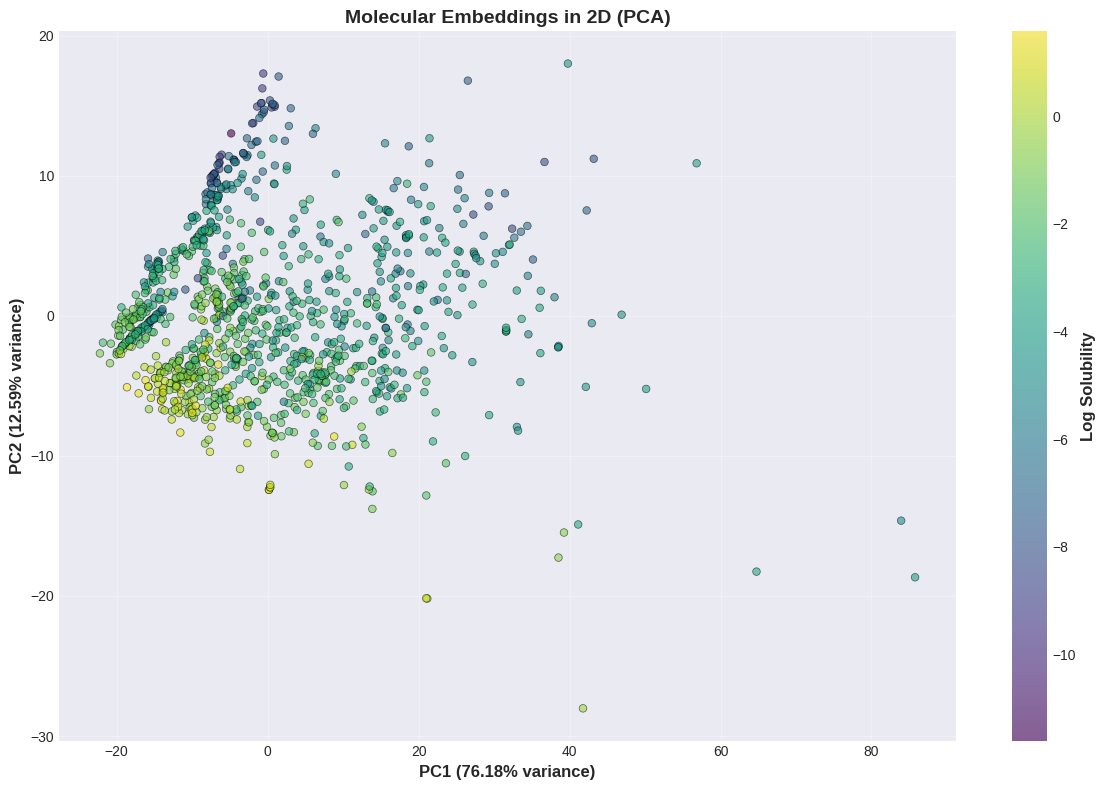


The GNN has learned to organize molecules by their solubility!
Similar molecules cluster together in the embedding space.


In [25]:
# Visualize embeddings with PCA
print('Performing PCA dimensionality reduction...')

# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_scaled)

print(f'PCA explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total variance explained: {pca.explained_variance_ratio_.sum():.3f}')

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=targets,
    cmap='viridis',
    s=30,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
              fontsize=12, fontweight='bold')
ax.set_title('Molecular Embeddings in 2D (PCA)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log Solubility', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print('\nThe GNN has learned to organize molecules by their solubility!')
print('Similar molecules cluster together in the embedding space.')

# On Graph neural networks

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/graph_atributes.png?raw=true)

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gn.png?raw=true)

https://rusty1s.github.io/pytorch_geometric/build/html/modules/nn.html#torch_geometric.nn.meta.MetaLayer

## How to tune the best architecture

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/bayesopt.gif?raw=true)


* https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
* https://github.com/SheffieldML/GPyOpt
* https://github.com/automl/pysmac
* http://sheffieldml.github.io/GPyOpt/

# Bayesian Optimization utilities (supports both v1.x and v2.0+ APIs)

In [46]:
from matplotlib import gridspec

def posterior(optimizer, x_obs, y_obs, grid):
    """Calculate posterior mean and std from GP"""
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y):
    """
    Visualize Gaussian Process and Utility/Acquisition Function
    Compatible with both bayesian-optimization v1.x and v2.0+ APIs
    """
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        f'Gaussian Process and Acquisition Function After {steps} Steps',
        fontsize=24, # Use fontsize directly
        fontweight='bold' # Use fontweight directly
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    # Get observations
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    # Calculate posterior
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)

    # Plot target function
    axis.plot(x, y, linewidth=3, label='Target Function', color=GOMES_COLORS['navy'])

    # Plot observations
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=10,
             label='Observations', color=GOMES_COLORS['coral'])

    # Plot GP prediction
    axis.plot(x, mu, '--', color='k', linewidth=2, label='GP Mean')

    # Plot confidence interval
    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.96 * sigma, (mu + 1.96 * sigma)[::-1]]),
        alpha=0.3, fc=GOMES_COLORS['teal'], ec='None',
        label='95% Confidence Interval'
    )

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size': 16})
    axis.set_xlabel('x', fontdict={'size': 16})
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=12)
    axis.grid(True, alpha=0.3)

    # Plot acquisition function (version-dependent)
    if BAYESOPT_VERSION == 'v1.x':
        # v1.x API: UtilityFunction
        utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
        acquisition_values = utility_function.utility(x, optimizer._gp, 0)
        label_text = 'Utility Function (v1.x)'
    elif BAYESOPT_VERSION == 'v2.0+':
        # v2.0+ API: UpperConfidenceBound
        acquisition_function = UpperConfidenceBound(kappa=5)
        x_2d = x.reshape(-1, 1)  # v2.0+ requires 2D input
        acquisition_values = acquisition_function.compute(
            x_2d,
            optimizer._gp,
            optimizer.space.target.max()
        ).flatten()  # Flatten back to 1D for plotting
        label_text = 'Acquisition Function (v2.0+)'
    else:
        raise RuntimeError("No bayesian-optimization API available")

    acq.plot(x, acquisition_values, label=label_text,
            color=GOMES_COLORS['navy'], linewidth=2)
    acq.plot(x[np.argmax(acquisition_values)], np.max(acquisition_values), '*',
            markersize=20, label='Next Sample Point',
            markerfacecolor='gold', markeredgecolor='k', markeredgewidth=2)

    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(acquisition_values) + 0.5))
    acq.set_ylabel('Acquisition Value', fontdict={'size': 16})
    acq.set_xlabel('x', fontdict={'size': 16})
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=12)
    acq.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig


print('Bayesian Optimization utilities loaded')
print(f'API Version: {BAYESOPT_VERSION}')
print('Functions: posterior(), plot_gp()')
print('\nℹ️  This code works with both bayesian-optimization v1.x and v2.0+ APIs')

Bayesian Optimization utilities loaded
API Version: v2.0+
Functions: posterior(), plot_gp()

ℹ️  This code works with both bayesian-optimization v1.x and v2.0+ APIs


In [47]:
# Bayesian Optimization utilities (modernized)
# Using the latest bayesian-optimization package

from matplotlib import gridspec
from bayes_opt.acquisition import UpperConfidenceBound # Import for v2.0+ API

def posterior(optimizer, x_obs, y_obs, grid):
    """Calculate posterior mean and std from GP"""
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y):
    """
    Visualize Gaussian Process and Utility Function
    """
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        f'Gaussian Process and Utility Function After {steps} Steps',
        fontsize=24, # Use fontsize directly
        fontweight='bold' # Use fontweight directly
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    # Get observations
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    # Calculate posterior
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)

    # Plot target function
    axis.plot(x, y, linewidth=3, label='Target Function', color=GOMES_COLORS['navy'])

    # Plot observations
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=10,
             label='Observations', color=GOMES_COLORS['coral'])

    # Plot GP prediction
    axis.plot(x, mu, '--', color='k', linewidth=2, label='GP Mean')

    # Plot confidence interval
    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.96 * sigma, (mu + 1.96 * sigma)[::-1]]),
        alpha=0.3, fc=GOMES_COLORS['teal'], ec='None',
        label='95% Confidence Interval'
    )

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size': 16})
    axis.set_xlabel('x', fontdict={'size': 16})
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=12)
    axis.grid(True, alpha=0.3)

    # Plot acquisition function (using v2.0+ API)
    acquisition_function = UpperConfidenceBound(kappa=5)
    x_2d = x.reshape(-1, 1) # v2.0+ requires 2D input
    utility = acquisition_function.compute(
        x_2d,
        optimizer._gp,
        optimizer.space.target.max()
    ).flatten() # Flatten back to 1D for plotting

    acq.plot(x, utility, label='Acquisition Function',
            color=GOMES_COLORS['navy'], linewidth=2)
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=20,
            label='Next Sample Point', markerfacecolor='gold',
            markeredgecolor='k', markeredgewidth=2)

    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Acquisition Value', fontdict={'size': 16})
    acq.set_xlabel('x', fontdict={'size': 16})
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=12)
    acq.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig


print('Bayesian Optimization utilities loaded')
print('Functions: posterior(), plot_gp()')

Bayesian Optimization utilities loaded
Functions: posterior(), plot_gp()


## black box function

In [48]:
# Define black box function to optimize
def target(x):
    """
    Complex function with multiple peaks
    Goal: Find the global maximum
    """
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)


print('Black box function defined: f(x) with multiple peaks')
print('Goal: Find x that maximizes f(x) in range [-2, 10]')

Black box function defined: f(x) with multiple peaks
Goal: Find x that maximizes f(x) in range [-2, 10]


### lets take a gander

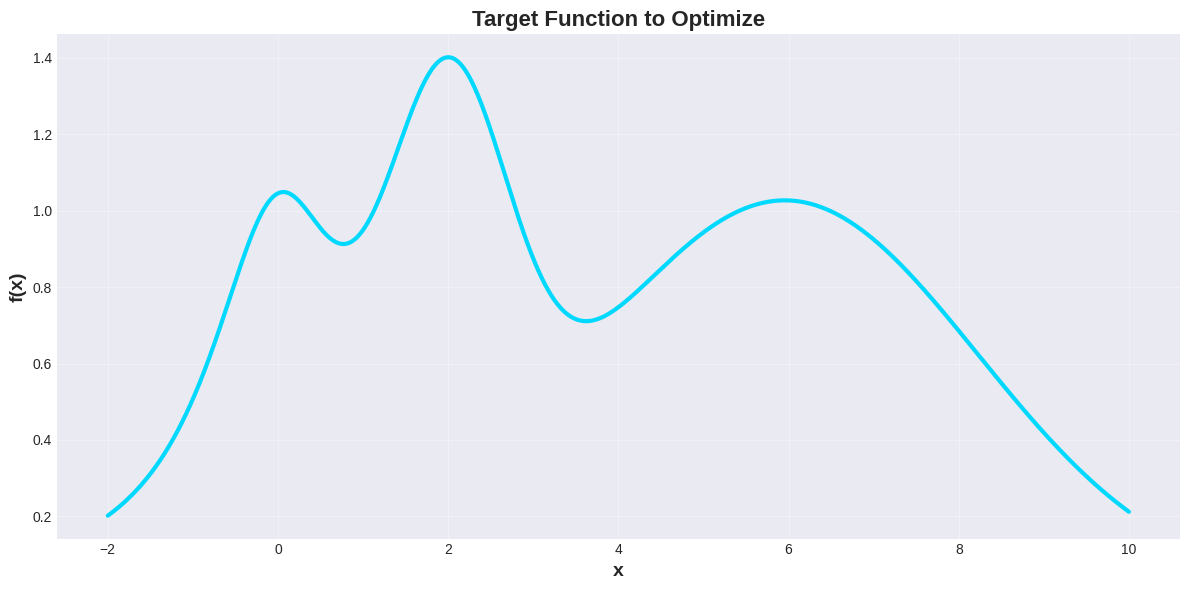

Global maximum appears to be around x ≈ 2.0
True maximum: f(2.001) = 1.402


In [49]:
# Visualize the target function
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, y, linewidth=3, color=GOMES_COLORS['teal'])
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('f(x)', fontsize=14, fontweight='bold')
ax.set_title('Target Function to Optimize', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print(f'Global maximum appears to be around x ≈ 2.0')
print(f'True maximum: f({x[np.argmax(y)][0]:.3f}) = {y.max():.3f}')

In [50]:
# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=target,
    pbounds={'x': (-2, 10)},
    random_state=42,
    verbose=2
)

# Start with one random sample
# In bayesian-optimization v2.0+, 'kappa' is specified in the acquisition function, not maximize()
optimizer.maximize(init_points=1, n_iter=0)

print('\nBayesian Optimization initialized with 1 random sample')

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 1.2141683 | 2.4944814 |

Bayesian Optimization initialized with 1 random sample


## Iterative

Running Bayesian Optimization iterations...

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 1.2141770 | 2.4944683 |

--- After 3 evaluations ---


AttributeError: 'UpperConfidenceBound' object has no attribute 'compute'

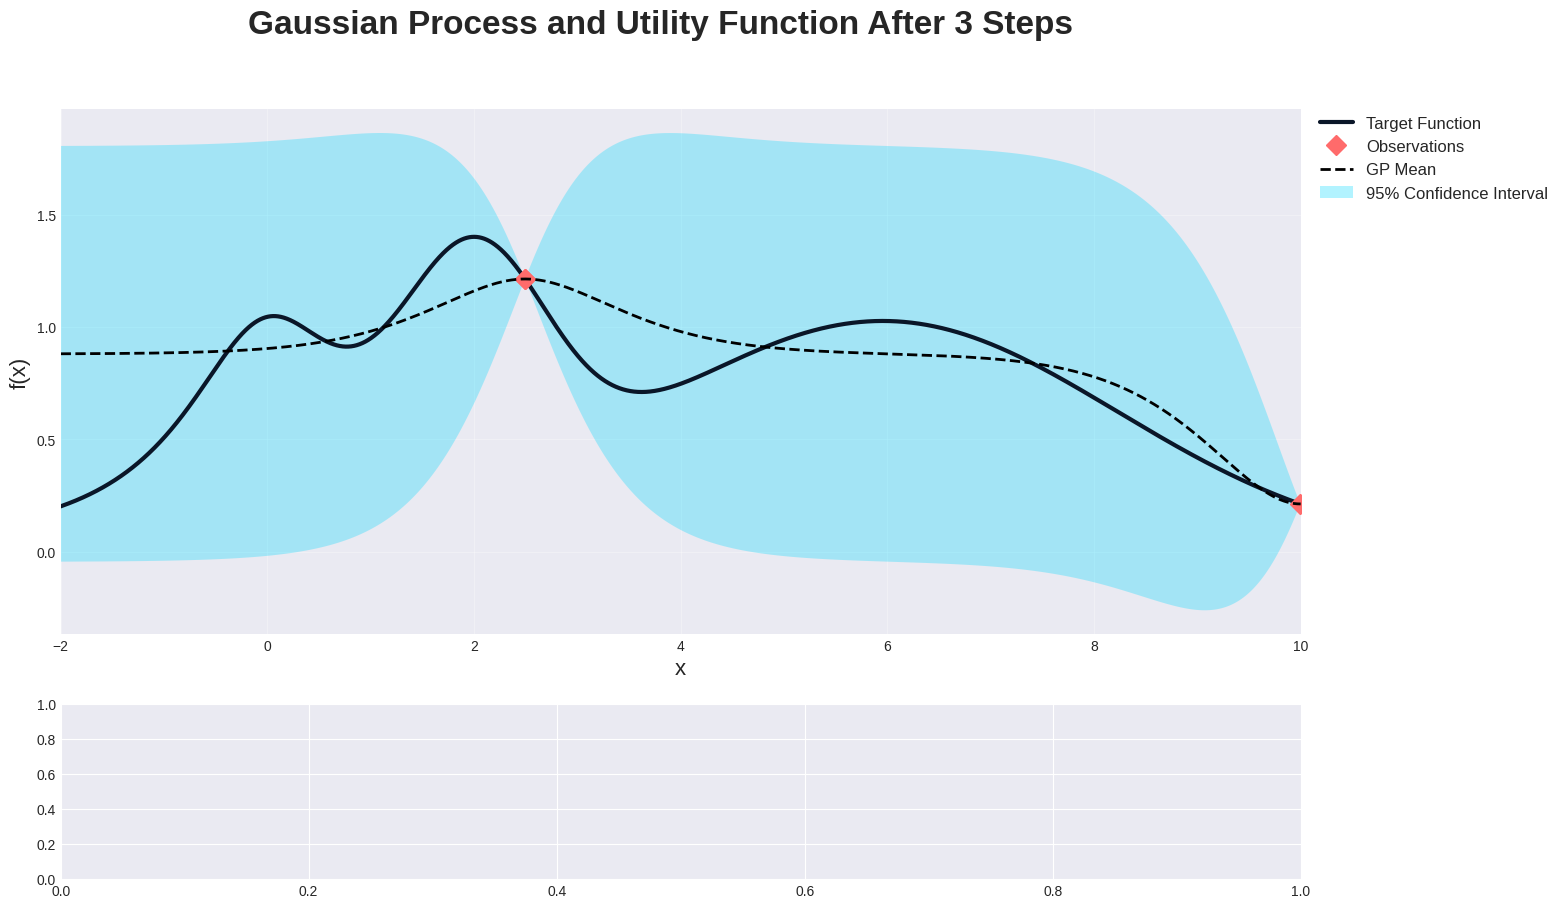

In [53]:
# Iterative Bayesian Optimization
# Run multiple iterations and visualize the process

print('Running Bayesian Optimization iterations...\n')

for i in range(5):
    # Perform one iteration
    # In bayesian-optimization v2.0+, 'kappa' is specified in the acquisition function, not maximize()
    optimizer.maximize(init_points=0, n_iter=1)

    # Plot current state
    print(f'\n--- After {len(optimizer.space)} evaluations ---')
    plot_gp(optimizer, x, y)
    plt.show()

    # Print current best
    best_params = optimizer.max['params']
    best_target = optimizer.max['target']
    print(f'Current best: x = {best_params["x"]:.4f}, f(x) = {best_target:.4f}')

print('\nBayesian Optimization complete!')
print(f'Final best: x = {optimizer.max["params"]["x"]:.4f}')
print(f'Final best value: f(x) = {optimizer.max["target"]:.4f}')

## Uncertainty quantification

In [56]:
# Uncertainty Quantification through Model Ensembles
# Train multiple models with different hyperparameters

def create_and_train_model(hparams, train_loader, test_loader, max_epochs=50):
    """
    Helper function to create and train a model with specific hyperparameters
    """
    model = MoleculeGNN(
        num_atom_features=9,
        num_bond_features=3,
        hidden_channels=hparams['hidden_channels'],
        num_conv_layers=hparams['num_conv_layers'],
        embedding_dim=hparams['embedding_dim'],
        dropout=hparams['dropout'],
        conv_activation=hparams['conv_activation'],
        pool_activation=hparams['pool_activation'],
        learning_rate=hparams['learning_rate']
    )

    # Quick training without verbose output
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        devices=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=False,
        enable_checkpointing=False
    )

    trainer.fit(model, train_loader, test_loader)

    return model


# Define ensemble hyperparameters (varied configurations)
ensemble_hparams = [
    {'hidden_channels': 32, 'num_conv_layers': 3, 'embedding_dim': 128,
     'dropout': 0.0, 'conv_activation': 'relu', 'pool_activation': 'softplus',
     'learning_rate': 0.001},

    {'hidden_channels': 48, 'num_conv_layers': 4, 'embedding_dim': 150,
     'dropout': 0.1, 'conv_activation': 'relu', 'pool_activation': 'sigmoid',
     'learning_rate': 0.0005},

    {'hidden_channels': 40, 'num_conv_layers': 3, 'embedding_dim': 140,
     'dropout': 0.05, 'conv_activation': 'relu', 'pool_activation': 'softmax',
     'learning_rate': 0.002},

    {'hidden_channels': 36, 'num_conv_layers': 4, 'embedding_dim': 120,
     'dropout': 0.15, 'conv_activation': 'relu', 'pool_activation': 'sigmoid',
     'learning_rate': 0.001},

    {'hidden_channels': 44, 'num_conv_layers': 3, 'embedding_dim': 160,
     'dropout': 0.08, 'conv_activation': 'relu', 'pool_activation': 'tanh',
     'learning_rate': 0.0015},
]

print(f'Training ensemble of {len(ensemble_hparams)} models...')
print('This may take a few minutes...\n')

ensemble_models = []
ensemble_scores = []

for i, hparams in enumerate(tqdm(ensemble_hparams)):
    model = create_and_train_model(hparams, train_loader, test_loader, max_epochs=30)
    ensemble_models.append(model)

    # Evaluate model
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            pred = model(batch)
            preds.append(pred.cpu().numpy())

    y_pred = np.concatenate(preds, axis=0).ravel()
    r2 = metrics.r2_score(y_test, y_pred)
    ensemble_scores.append(r2)

    print(f'Model {i+1}: R² = {r2:.4f}')

print(f'\nEnsemble training complete!')
print(f'Average R²: {np.mean(ensemble_scores):.4f} \u00b1 {np.std(ensemble_scores):.4f}')

Training ensemble of 5 models...
This may take a few minutes...



  0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
 20%|██        | 1/5 [00:06<00:24,  6.13s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model 1: R² = 0.7606


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
 40%|████      | 2/5 [00:14<00:22,  7.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model 2: R² = 0.8005


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
 60%|██████    | 3/5 [00:21<00:14,  7.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model 3: R² = 0.3500


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
 80%|████████  | 4/5 [00:30<00:07,  7.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model 4: R² = 0.7542


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
100%|██████████| 5/5 [00:37<00:00,  7.47s/it]

Model 5: R² = 0.7875

Ensemble training complete!
Average R²: 0.6906 ± 0.1711


In [57]:
# Get ensemble predictions and compute uncertainty
print('Computing ensemble predictions and uncertainties...')

# Collect predictions from all models
all_preds = []

for model in ensemble_models:
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            pred = model(batch) # Fixed: Expect only one return value from MoleculeGNN
            preds.append(pred.cpu().numpy())

    y_pred = np.concatenate(preds, axis=0).ravel()
    all_preds.append(y_pred)

# Convert to array: shape (num_models, num_samples)
all_preds = np.array(all_preds)

print(f'Predictions shape: {all_preds.shape}')

# Compute ensemble statistics
ensemble_mean = np.mean(all_preds, axis=0)
ensemble_std = np.std(all_preds, axis=0)  # Epistemic uncertainty

# Ensemble performance
r2_ensemble = metrics.r2_score(y_test, ensemble_mean)
mae_ensemble = metrics.mean_absolute_error(y_test, ensemble_mean)

print(f'\nEnsemble Performance:')
print(f'  R² Score: {r2_ensemble:.4f}')
print(f'  MAE: {mae_ensemble:.4f}')
print(f'\nUncertainty Statistics:')
print(f'  Mean uncertainty (std): {ensemble_std.mean():.4f}')
print(f'  Min uncertainty: {ensemble_std.min():.4f}')
print(f'  Max uncertainty: {ensemble_std.max():.4f}')

Computing ensemble predictions and uncertainties...
Predictions shape: (5, 226)

Ensemble Performance:
  R² Score: 0.7805
  MAE: 0.7691

Uncertainty Statistics:
  Mean uncertainty (std): 0.5327
  Min uncertainty: 0.0826
  Max uncertainty: 2.7229


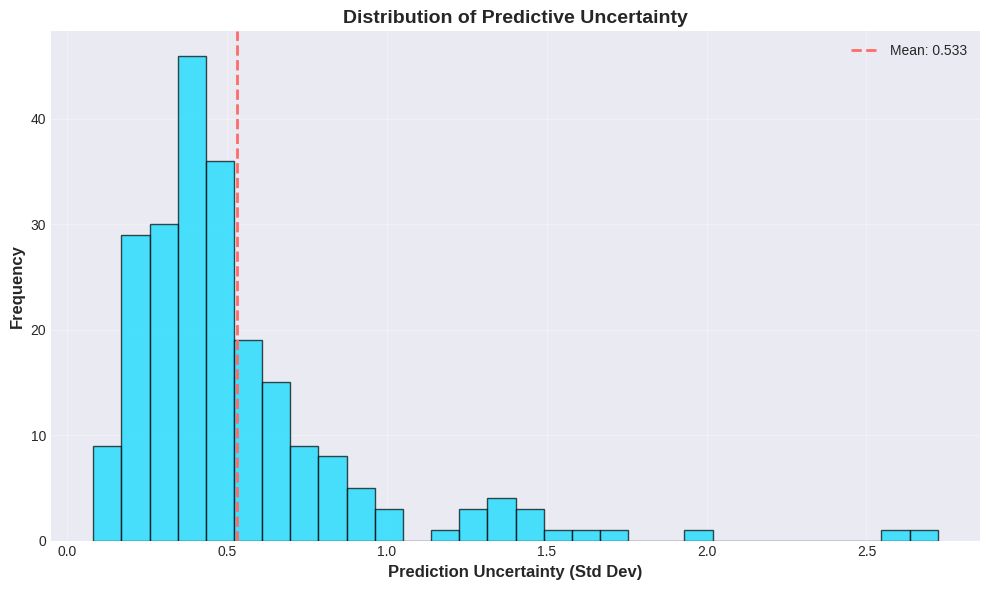

Higher uncertainty indicates disagreement among ensemble members
This often correlates with difficult predictions or out-of-distribution samples


In [58]:
# Visualize uncertainty distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(ensemble_std, bins=30, color=GOMES_COLORS['teal'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Prediction Uncertainty (Std Dev)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Predictive Uncertainty', fontsize=14, fontweight='bold')
ax.axvline(ensemble_std.mean(), color=GOMES_COLORS['coral'],
          linestyle='--', linewidth=2, label=f'Mean: {ensemble_std.mean():.3f}')
ax.legend()
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print('Higher uncertainty indicates disagreement among ensemble members')
print('This often correlates with difficult predictions or out-of-distribution samples')

In [61]:
# Alternative: Monte Carlo Dropout for Uncertainty Quantification
# This is a modern approach that doesn't require training multiple models

class MCDropoutGNN(MoleculeGNN):
    """
    GNN with Monte Carlo Dropout for uncertainty estimation
    Dropout is applied during inference to sample from the posterior
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def enable_dropout(self):
        """Enable dropout during inference"""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    def mc_predict(self, batch, n_samples=100):
        """
        Perform MC Dropout prediction
        Returns: mean and std of predictions
        """
        self.eval()
        self.enable_dropout()

        predictions = []
        with torch.no_grad():
            for _ in range(n_samples):
                pred = self(batch) # Fixed: Expect only one return value from MoleculeGNN's forward
                predictions.append(pred.cpu().numpy())

        predictions = np.array(predictions)
        mean_pred = predictions.mean(axis=0)
        std_pred = predictions.std(axis=0)

        return mean_pred, std_pred


print('MC Dropout GNN class defined')
print('Use mc_predict() to get uncertainty estimates from dropout sampling')
print('\nNote: For faster notebook execution, this is provided as an example')
print('Uncomment the training code below to use MC Dropout')

MC Dropout GNN class defined
Use mc_predict() to get uncertainty estimates from dropout sampling

Note: For faster notebook execution, this is provided as an example
Uncomment the training code below to use MC Dropout


In [62]:
# Example MC Dropout usage (commented out for speed)
# Uncomment to use MC Dropout instead of ensemble

mc_model = MCDropoutGNN(
    num_atom_features=9,
    num_bond_features=3,
    hidden_channels=48,
    num_conv_layers=4,
    embedding_dim=128,
    dropout=0.2,  # Important: use higher dropout for MC Dropout
    learning_rate=0.001
)

trainer = pl.Trainer(max_epochs=50, accelerator='auto', devices=1)
trainer.fit(mc_model, train_loader, test_loader)

# Get MC Dropout predictions
mc_model.eval()
mc_means = []
mc_stds = []

for batch in test_loader:
    mean_pred, std_pred = mc_model.mc_predict(batch, n_samples=50)
    mc_means.append(mean_pred)
    mc_stds.append(std_pred)

mc_predictions = np.concatenate(mc_means, axis=0).ravel()
mc_uncertainties = np.concatenate(mc_stds, axis=0).ravel()

r2_mc = metrics.r2_score(y_test, mc_predictions)
print(f'MC Dropout R² Score: {r2_mc:.4f}')

print('MC Dropout training code (commented out)')
print('This provides an alternative to ensembles for uncertainty estimation')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type         | Params
------------------------------------------------
0 | atom_embedding | Embedding    | 5.7 K 
1 | convs          | ModuleList   | 50.3 K
2 | pool           | GraphPooling | 24.7 K
3 | dropout        | Dropout      | 0     
4 | predictor      | Linear       | 129   
------------------------------------------------
80.8 K    Trainable params
0         Non-trainable params
80.8 K    Total params
0.323     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


MC Dropout R² Score: 0.3499
MC Dropout training code (commented out)
This provides an alternative to ensembles for uncertainty estimation


Correlation Analysis:
  Pearson correlation: 0.1410
  P-value: 0.034170

Weak or no correlation.
Uncertainty estimates may need improvement.


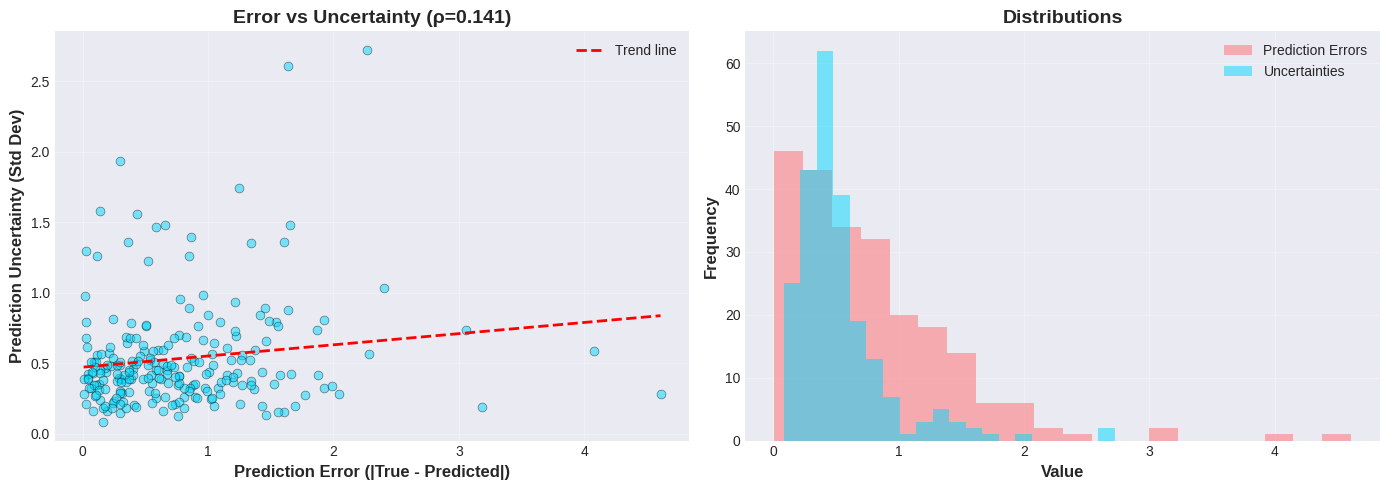

In [63]:
# Analyze correlation between prediction error and uncertainty
# Key insight: High uncertainty should correlate with high prediction error

# Calculate prediction errors
prediction_errors = np.abs(y_test - ensemble_mean)

# Calculate correlation
correlation, p_value = sp.stats.pearsonr(prediction_errors, ensemble_std)

print(f'Correlation Analysis:')
print(f'  Pearson correlation: {correlation:.4f}')
print(f'  P-value: {p_value:.6f}')

if correlation > 0.3:
    print(f'\nPositive correlation detected!')
    print(f'Higher uncertainty is associated with larger prediction errors.')
    print(f'This validates the uncertainty estimates.')
else:
    print(f'\nWeak or no correlation.')
    print(f'Uncertainty estimates may need improvement.')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Error vs Uncertainty
axes[0].scatter(prediction_errors, ensemble_std, alpha=0.5,
               c=GOMES_COLORS['teal'], s=40, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('Prediction Error (|True - Predicted|)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Prediction Uncertainty (Std Dev)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Error vs Uncertainty (ρ={correlation:.3f})',
                 fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(prediction_errors, ensemble_std, 1)
p = np.poly1d(z)
axes[0].plot(np.sort(prediction_errors), p(np.sort(prediction_errors)),
            "r--", linewidth=2, label='Trend line')
axes[0].legend()

# Histogram: Distribution comparison
axes[1].hist(prediction_errors, bins=20, alpha=0.5,
            label='Prediction Errors', color=GOMES_COLORS['coral'])
axes[1].hist(ensemble_std, bins=20, alpha=0.5,
            label='Uncertainties', color=GOMES_COLORS['teal'])
axes[1].set_xlabel('Value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distributions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [64]:
# Summary: Uncertainty Quantification Methods

print('=' * 80)
print('UNCERTAINTY QUANTIFICATION SUMMARY')
print('=' * 80)

print('\nMethods Covered:')
print('\n1. Model Ensembles (Epistemic Uncertainty)')
print('   - Train multiple models with different hyperparameters')
print('   - Variance across models indicates uncertainty')
print('   - Pros: Reliable, interpretable')
print('   - Cons: Computationally expensive (multiple trainings)')

print('\n2. Monte Carlo Dropout (Aleatoric + Epistemic Uncertainty)')
print('   - Single model with dropout enabled during inference')
print('   - Multiple forward passes with different dropout masks')
print('   - Pros: Efficient, only one model needed')
print('   - Cons: Requires careful dropout tuning')

print('\n3. Bayesian Neural Networks (Full Bayesian Treatment)')
print('   - Learn distributions over weights instead of point estimates')
print('   - Libraries: Pyro, PyTorch Uncertainty, Bayesian-Torch')
print('   - Pros: Theoretically principled')
print('   - Cons: Complex implementation, expensive inference')

print('\nKey Takeaways:')
print('- Uncertainty quantification is crucial for reliable ML in chemistry')
print('- High uncertainty → low confidence → need more data or better model')
print('- Uncertainty estimates should correlate with prediction errors')
print('- Ensembles are simple and effective for most applications')

print('\nFurther Reading:')
print('- Gal & Ghahramani (2016): Dropout as Bayesian Approximation')
print('- Lakshminarayanan et al. (2017): Simple and Scalable Ensembles')
print('- Intel Bayesian-Torch: github.com/IntelLabs/bayesian-torch')
print('- TorchUncertainty: github.com/ENSTA-U2IS/torch-uncertainty')

print('\n' + '=' * 80)

UNCERTAINTY QUANTIFICATION SUMMARY

Methods Covered:

1. Model Ensembles (Epistemic Uncertainty)
   - Train multiple models with different hyperparameters
   - Variance across models indicates uncertainty
   - Pros: Reliable, interpretable
   - Cons: Computationally expensive (multiple trainings)

2. Monte Carlo Dropout (Aleatoric + Epistemic Uncertainty)
   - Single model with dropout enabled during inference
   - Multiple forward passes with different dropout masks
   - Pros: Efficient, only one model needed
   - Cons: Requires careful dropout tuning

3. Bayesian Neural Networks (Full Bayesian Treatment)
   - Learn distributions over weights instead of point estimates
   - Libraries: Pyro, PyTorch Uncertainty, Bayesian-Torch
   - Pros: Theoretically principled
   - Cons: Complex implementation, expensive inference

Key Takeaways:
- Uncertainty quantification is crucial for reliable ML in chemistry
- High uncertainty → low confidence → need more data or better model
- Uncertainty esti